In [2]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import h5py
import glob
import pmefm
reload(pmefm)
from collections import OrderedDict
from kpfm.util import h5filename
from kpfm.util import kpfm_data
import sigutils
from kpfm import lockin
from kpfm import util
reload(util)
reload(lockin)

ks = 14950.0

from scipy import integrate
def ck(f, x0, A, k):
    out = integrate.quad(lambda theta: f(x0 + A * np.cos(theta)) * np.cos(theta*k), -np.pi, np.pi)
    if k == 0:
        return out[0]/(2*np.pi)
    else:
        return out[0]/np.pi

@h5filename
def _h5toPMEFM(f):
    phi_t = f['CPD'][:]
    fs = f.attrs['Inputs.Scan rate [Hz]']
    dt = 1/fs
    T = phi_t.size * dt
    fx = f.attrs['Inputs.Pos Mod Freq (Hz)']
    x_m = f.attrs['Inputs.Pos Mod rms (V)'] * np.sqrt(2) * 0.2 * 15 * 0.167 
    x_tot = (f.attrs['Inputs.End scan [V]'] -
             f.attrs['Inputs.Start scan [V]']) * 0.125
    v_tip = x_tot / T

    return {'fs': fs, 'fx': fx, 'v_tip': v_tip, 'x_m': x_m, 'phi_t': phi_t}

In [69]:
plt.rc('font', size=8)

In [3]:
fh = h5py.File('../data/KPFM-linescans/170217-1657DPh-BTBT-20V-50-nm-x-mod.h5', 'r')

In [4]:
d = _h5toPMEFM(fh)
ks = d['fs'] / d['v_tip']
fir2 = lockin.lock2(4.5/d['v_tip'], 1.1 , 1.1*4, ks)

Response:
f   mag       dB
   0.000 1.000    0.000
   0.550 0.983   -0.151
   1.100 0.927   -0.656
   4.400 0.095  -20.488
   6.063 0.002  -53.440
   8.800 0.000 -101.830
  12.126 0.000 -114.106
11037.642 0.000 -345.562


In [5]:
CPD = signal.fftconvolve(fh['CPD'][:], fir2, 'valid')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0930874634694
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 9


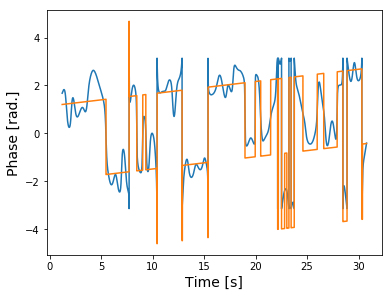

In [6]:
p25 = pmefm.PMEFMEx(**_h5toPMEFM('../data/KPFM-linescans/170217-1631DPh-BTBT-20V-25-nm-mod-x.h5'))
p25.fir_filter(fir_ac=fir2, fir_dc=fir2)
p25.auto_phase()
p25.plot_phase()
p25.output()

/Users/ryandwyer/Documents/Programming/mypython/pmefm/pmefm.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  self.k0_dc = jn_zeros(0, 1)[0] / (2 * np.pi * x_m)
/Users/ryandwyer/Documents/Programming/mypython/pmefm/pmefm.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  self.k0_ac = jn_zeros(1, 1)[0] / (2 * np.pi * x_m)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.102689978933
            Iterations: 10
            Function evaluations: 43
            Gradient evaluations: 10


/Users/ryandwyer/Documents/Programming/mypython/pmefm/pmefm.py:438: RuntimeWarning: divide by zero encountered in true_divide
  self.E_mod = self.V_ac / self.x_m


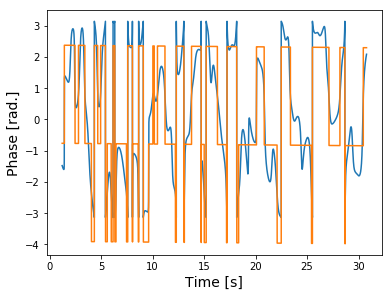

In [7]:
p0 = pmefm.PMEFMEx(**_h5toPMEFM('../data/KPFM-linescans/170217-1620DPh-BTBT-20V-no-mod-in-x-low-feedback.h5'))
p0.fir_filter(fir_ac=fir2, fir_dc=fir2)
p0.auto_phase()
p0.plot_phase()
p0.output()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0855476269131
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6


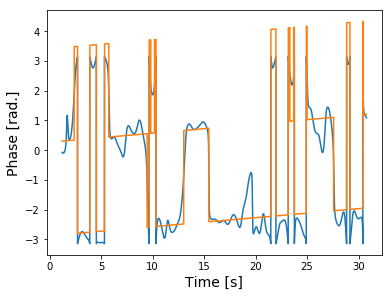

In [8]:
p50 = pmefm.PMEFMEx(**_h5toPMEFM('../data/KPFM-linescans/170217-1628DPh-BTBT-20V-50-nm-mod-x.h5'))
p50.fir_filter(fir_ac=fir2, fir_dc=fir2)
p50.auto_phase()
p50.plot_phase()
p50.output()

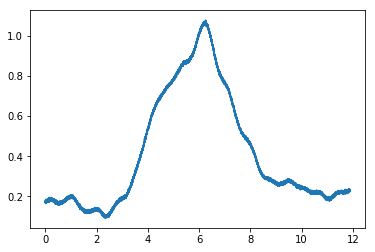

In [9]:
plt.plot(p0.x_dc, p0.phi)
# plt.plot(p50.x_dc, p50.phi)

In [10]:
li = lockin.LockIn(p50.t, p50.phi)

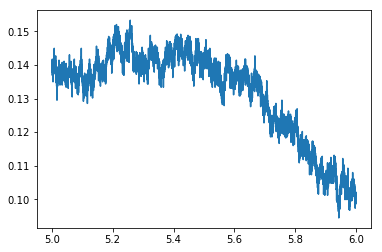

In [11]:
mask = (p50.t > 5) & (p50.t < 6)

plt.plot(p50.t[mask], p50.phi[mask])

In [12]:
m = kpfm_data("../data/KPFM/Feb 17 15-54  image 1.txt")

In [13]:
m.dx = np.mean(np.gradient(m.vx)) * 0.125
m.dy = np.mean(np.gradient(m.vy)) * 0.125

In [14]:
Ex, Ey = np.gradient(m.ch1)
m.Ex, m.Ey = Ex/m.dx, Ey/m.dy

In [15]:
Vx, Vy = np.meshgrid(m.vx, m.vy)

In [16]:
y = (m.vx - m.vx.mean()) * 0.125
x = (m.vy - m.vy.min()) * 0.125
Vx_ = (Vx - Vx.mean()) * 0.125
Vy_ = (Vy - Vy.min()) * 0.125
X, Y = Vy_, Vx_

In [17]:
xx = np.linspace(2, 9, 200)

In [18]:
from scipy import interpolate

In [19]:
interp2d = interpolate.RectBivariateSpline(x, y, m.ch1.T)

In [20]:
CH1 = np.fft.fft2(m.ch1.T)

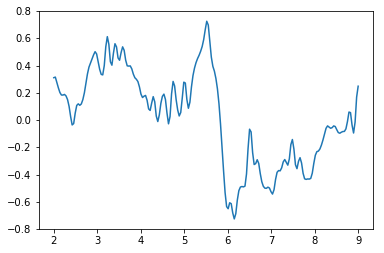

In [21]:
plt.plot(xx, interp2d.ev(xx, -2.5, dx=1))

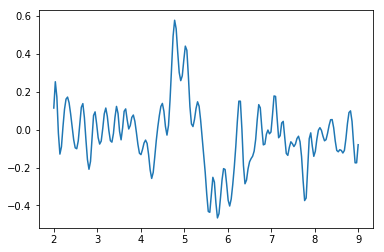

In [22]:
plt.plot(xx, interp2d.ev(xx, -2.5, dy=1))

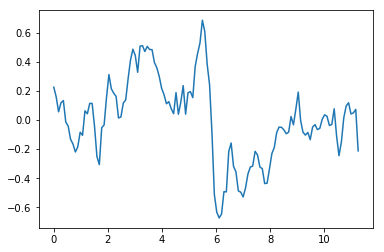

In [23]:
plt.plot(x, interp2d.ev(x, -2.5, dx=1))

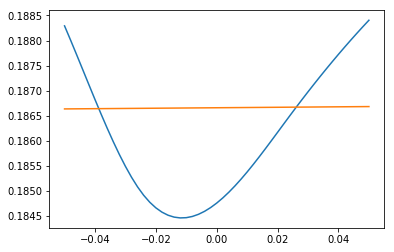

In [24]:
A = 0.05
yA = np.linspace(-A, A, 51)

c1 = ck(lambda x: interp2d(2.0, x, grid=False), 0, A, 1)
c0 = ck(lambda x: interp2d(2.0, x, grid=False), 0, A, 0)
plt.plot(yA, interp2d(2.0, yA, grid=False))
plt.plot(yA, c0 + c1*yA)

In [25]:
x00 = xx
y0 = -2.5

y00 = interp2d(xx, y0, grid=False)
x01 = xx
y01 = -interp2d.ev(xx, y0, dx=1)
x02 = xx
y02 = -interp2d.ev(xx, y0, dy=1)

A = 0.06

yA = np.linspace(-A, A, 51)

c1 = lambda x: ck(lambda y: interp2d(x, y0+y, grid=False), 0, A, 1)
c0 = lambda x: ck(lambda y: interp2d(x, y0+y, grid=False), 0, A, 0)


c0x = np.array([c0(x) for x in xx])
c1x = -np.array([c1(x) for x in xx])/A





In [26]:
c0x_d = -np.gradient(c0x)/np.gradient(xx)

In [27]:
d = np.mean(np.gradient(xx))
freq = np.fft.rfftfreq(y00.size, d=d)

mV = 1000

PHI = np.fft.rfft(y00.squeeze()*signal.blackman(y00.size)) / y00.size * d * mV
C0  = np.fft.rfft(c0x*signal.blackman(y00.size)) / c0x.size * d * mV
EX = np.fft.rfft(y01.squeeze()*signal.blackman(y00.size)) / y01.size * d * mV * A
C0X = np.fft.rfft(c0x_d*signal.blackman(y00.size)) / c0x_d.size * d * mV * A

EY = np.fft.rfft(y02.squeeze()*signal.blackman(y00.size)) / y02.size * d * mV * A
C1 = np.fft.rfft(c1x*signal.blackman(y00.size)) / c1x.size * d* mV * A

In [28]:
np.argmax((y00.squeeze() - c0x) *1e3)

122

In [29]:
xx[122]

6.291457286432161

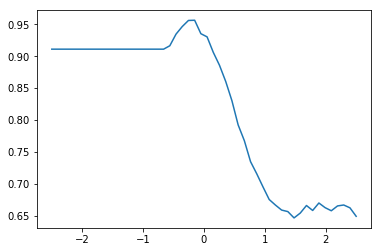

In [30]:
yy = np.linspace(-2.5, 2.5)
plt.plot(yy, interp2d(xx[122], yy+y0, grid=False))

In [31]:
ii = np.argmax( abs((y01.squeeze() - c0x_d) * 1e3 ))
xx[ii]

3.3366834170854274

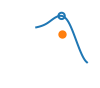

In [168]:
yy = np.linspace(-0.06, 0.06)
x0 = xx[ii]
fig, ax = plt.subplots(figsize=(1, 1), )
ax.set_axis_off()
l1, = plt.plot(yy, -interp2d(x0, yy+y0, grid=False, dx=1), linewidth=2)
l2, = plt.plot(0, c0x_d[ii])
plt.scatter(0, -interp2d(x0, y0, grid=False, dx=1), s=40, c='none', edgecolors=l1.get_color(), linewidths=2)
# plt.scatter(0, interp2d(x0, y0, grid=False), s=40, c='none', edgecolors=l1.get_color(),linewidths=2 )
plt.scatter(0, c0x_d[ii], s=40, c=l2.get_color(), edgecolors=l2.get_color(), linewidths=2)

In [169]:
fig.savefig('../figs/SI-Ex-erro-2r.pdf', transparent=True)

In [44]:
# !cp ../figs/SI-Ex-error.pdf \
#     /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201705__PMKPFM__figs/

In [45]:
i3 = np.argmax( abs((y02.squeeze() - c1x) * 1e3 ))
xx[i3]

4.7788944723618094

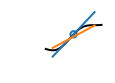

In [36]:
yy = np.linspace(-0.06, 0.06)
yyy = np.linspace(-0.045, 0.045)
x0 = xx[i3]
fig, ax = plt.subplots(figsize=(1.1, 0.9), )
ax.set_axis_off()
l1, = plt.plot(0, interp2d(x0, y0, grid=False, dy=0))
plt.plot(yy, interp2d(x0, yy+y0, grid=False, dy=0), linewidth=2, color='k')
plt.plot(yyy, interp2d(x0, y0, grid=False, dy=1)*yyy + interp2d(x0, y0, grid=False, dy=0), color=l1.get_color(), linewidth=2)
l2, = plt.plot(yyy, c0x[i3] - c1x[i3] * yyy, linewidth=2)
plt.scatter(0, interp2d(x0, y0, grid=False, dy=0), s=40, c='none', edgecolors=l1.get_color(), linewidths=2)
# plt.scatter(0, interp2d(x0, y0, grid=False), s=40, c='none', edgecolors=l1.get_color(),linewidths=2 )
# 

In [37]:
# fig.savefig('../figs/SI-Ey-error.pdf', transparent=True)

In [38]:
# !cp ../figs/SI-Ey-error.pdf \
#     /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201705__PMKPFM__figs/

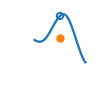

In [173]:

yy = np.linspace(-0.06, 0.06)
x0 = xx[122]
fig, ax = plt.subplots(figsize=(1, 1))
ax.set_axis_off()
l1, = plt.plot(yy, interp2d(x0, yy+y0, grid=False), linewidth=2.3)
l2, = plt.plot(0, c0x[122])
plt.scatter(0, interp2d(x0, y0, grid=False), s=40, c='none', edgecolors=l1.get_color(),linewidths=2)
# plt.scatter(0, interp2d(x0, y0, grid=False), s=40, c='none', edgecolors=l1.get_color(),linewidths=2 )
plt.scatter(0, c0x[122], s=40, c=l2.get_color(), edgecolors=l2.get_color(), linewidths=2)

In [174]:
fig.savefig('../figs/SI-phi-error-2.pdf', transparent=True)

In [172]:
# !cp ../figs/SI-phi-error.pdf \
#     /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201705__PMKPFM__figs/

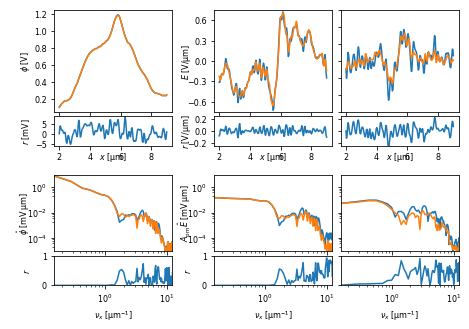

In [164]:
plt.rc('font', size=8)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(7.2, 5.2),
                         gridspec_kw={'height_ratios':
                                      (1.2, 0.35, 1, 0.35)
                                     }
                        )
axes[0, 0].plot(x00, y00)
axes[0, 0].plot(xx, c0x)
axes[0, 0].set_ylabel(u"$\\phi$ [V]")
axes[0, 1].plot(x01, y01)
axes[0, 1].plot(xx, c0x_d)
axes[0, 2].plot(x02, y02)
axes[0, 2].plot(xx, c1x)
axes[1, 0].set_ylabel(u"$r$ [mV]")
axes[1, 0].plot(xx, (y00.squeeze() - c0x) *1e3)

axes[1, 2].plot(x02, y02-c1x)
axes[1, 1].plot(x01, y01-c0x_d)
axes[2, 0].loglog(freq, abs(PHI))
axes[2, 0].loglog(freq, abs(C0))
axes[3, 0].semilogx(freq, abs(abs(PHI) - abs(C0)) / (abs(PHI) + abs(C0)))

axes[2, 1].loglog(freq, abs(EX))
axes[2, 1].loglog(freq, abs(C0X))

axes[3, 1].semilogx(freq, abs(abs(EX) - abs(C0X)) / (abs(EX) + abs(C0X)))

axes[2, 2].loglog(freq, abs(EY))
axes[2, 2].loglog(freq, abs(C1))


axes[3, 2].semilogx(freq, abs(abs(EY) - abs(C1)) / (abs(EY) + abs(C1)))

# axes[3, 2].semilogx(freq, abs(abs(EY) - abs(C1)) / (abs(EY) + abs(C1)))


for i, axr in enumerate(axes):
    for j, ax in enumerate(axr):
        if i >= 2:
            ax.set_xlim(0.15, 12)
            if (i == 2):
                ax.set_ylim(1e-5, 1e1)
            
            if i == 2:
                ax.set_xticklabels([''])
            
            
        if j == 0:
            pos1 = ax.get_position()
            pos2 = [pos1.x0-0.006, pos1.y0, pos1.width, pos1.height]
            ax.set_position(pos2)
            
        
        if j == 1:
            pos1 = ax.get_position()
            pos2 = [pos1.x0+0.029, pos1.y0, pos1.width, pos1.height]
            ax.set_position(pos2)
            
        
        if j == 2:
            pos1 = ax.get_position()
            pos2 = [pos1.x0, pos1.y0, pos1.width, pos1.height]
            ax.set_position(pos2)
        
        
        squeeze = 0.9
        if i == 0:
            ax.set_xticklabels([''])
            pos1 = ax.get_position()
            pos2 = [pos1.x0, pos1.y0, pos1.width, pos1.height]
            ax.set_position(pos2)
        
        if i == 1:
            pos1 = ax.get_position()
            pos2 = [pos1.x0, pos1.y0+0.022, pos1.width, pos1.height]
            ax.set_position(pos2)
            
        
        if i == 2:
            pos1 = ax.get_position()
            pos2 = [pos1.x0, pos1.y0, pos1.width, pos1.height*squeeze]
            ax.set_position(pos2)
        
        if i == 3:
            pos1 = ax.get_position()
            pos2 = [pos1.x0, pos1.y0+0.02, pos1.width, pos1.height]
            ax.set_position(pos2)
            
        if i == 1 and j >= 1:
            ax.set_yticks([-0.2, 0, 0.2])
        
        if i == 0:
            
            if j >= 1:
                ax.set_ylim(-0.75,0.75)
        
        if i == 1 and j == 1:
            ax.set_ylabel(u"$r$ [V/µm]")
            
        if i == 3 and j == 1:
            ax.set_ylabel(u"$r$")
        
        if i == 1:
            if j >= 1:
                ax.set_ylim(-0.25, 0.25)
        
        if i == 3:
            ax.set_ylim(0, 1)
        
        if j == 2:
            ax.set_yticklabels([''])
        
        if i == 0 and j == 1:
            ax.set_ylabel(u"$E$ [V/µm]")
            
        if i == 1:
            ax.set_xlabel(u"$x$ [µm]")
        
        if i == 3:
            ax.set_xlabel(u"$\\nu_{x}$ [µm⁻¹]")
            if j == 0:
                ax.set_ylabel(u"$r$")
        
        if i == 2 and j == 0:
            ax.set_ylabel(u'$\hat{\phi}$ [mV$\\,$µm]')
            
        if i == 2:
            ax.set_yticks([1e-4, 1e-2, 1])
            
        
        if i == 2 and j == 1:
            ax.set_ylabel(u"$A_{\mathrm{pm}} \hat{E}$ [mV$\\,$µm]")
        
        
axes[0, 1].set_yticks(np.linspace(-0.6, 0.6, 5))
util.align_labels(axes[1], lim=178, axis='x')
util.align_labels(axes.T[1], lim=193, axis='y')
util.align_labels(axes.T[0], lim=31.5, axis='y')


In [165]:
# plt.plot(y01-c0x_d, (y00.squeeze() - c0x), '.')

In [166]:
fig.savefig('../figs/large-messy-figure.pdf', transparent=True)

In [167]:
! open -a "Preview" '../figs/large-messy-figure.pdf'

In [128]:
# !cp ../figs/large-messy-figure.pdf \
#     /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201705__PMKPFM__figs/